# Iteration Between EDA and Feature Work
- Expect to loop
- EDA, feature selection, and feature engineering are not one-time steps. They should inform each other in cycles.
- Workflow
1. Explore data distributions and relationships in EDA.
2. Propose engineered features based on patterns or domain ideas.
3. Test them quickly with simple models or diagnostics.
4. If results are unhelpful (no signal, redundancy, instability), discard or revise.
5. Go back to EDA with new questions (e.g., “Why didn’t lag-7 help? Maybe seasonality is longer”).
- Mindset
- Don’t hoard features “just in case.” Keep the pipeline clean and only include features that survive scrutiny.
- Each iteration should strengthen your understanding of the data, not just expand the feature set.

## Imports & Settings

In [52]:
# Basic
import os
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px

# Import preprocessing (go up one level to src/)
import sys
sys.path.append("..")  
from src.features.preprocessing import preprocess_fit_transform

# Stats & ML
from scipy import stats
from sklearn.ensemble import IsolationForest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from src.features.preprocessing import preprocess_fit_transform
from src.features.transformers import DomainFeatureEngineer

# Display options
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

# Paths
PATH_REFINED = "../data/processed/merged_clean_refined.csv"


## Load Refined Dataset

In [53]:
# Load data
df = pd.read_csv(PATH_REFINED)
print("Shape:", df.shape)
df.head()

Shape: (4829, 20)


,from_league,to_league,Position,sub_position,position,foot,GA90_pre,GA_pre,PreMinutes,transfer_fee,market_value_in_eur,market_value_in_eur_player,highest_market_value_in_eur,country_of_birth,country_of_citizenship,height_in_cm,transfer_date,date_of_birth,contract_expiration_date,DeclineFlag
0,GR1,TR1,Midfielder,Central Midfield,Midfield,left,0.091993,3.0,2935.0,0.0,2000000.0,1500000.0,14000000.0,Netherlands,Netherlands,175.0,2025-02-07,1995-01-03 00:00:00,2025-06-30 00:00:00,0.0
1,GB1,NL1,FullBack,Left-Back,Defender,left,0.000000,0.0,1276.0,0.0,15000000.0,12000000.0,22000000.0,Netherlands,Netherlands,169.0,2025-02-04,1999-08-17 00:00:00,2025-06-30 00:00:00,1.0
2,IT1,IT1,FullBack,Left-Back,Defender,left,0.288462,15.0,4680.0,0.0,2000000.0,2000000.0,12000000.0,Italy,Italy,185.0,2025-02-03,1992-09-01 00:00:00,2025-06-30 00:00:00,1.0
3,ES1,ES1,FullBack,Left-Back,Defender,left,0.275229,4.0,1308.0,0.0,2500000.0,2500000.0,20000000.0,Spain,Spain,170.0,2025-02-03,1993-03-01 00:00:00,2025-06-30 00:00:00,1.0
4,GB1,SC1,Midfielder,Left Midfield,Midfield,left,0.284710,9.0,2845.0,0.0,6000000.0,5000000.0,12000000.0,Germany,Ghana,178.0,2025-02-03,1992-12-23 00:00:00,2025-05-31 00:00:00,1.0


Target distribution:
DeclineFlag
0.0    2937
1.0    1892
Name: count, dtype: int64


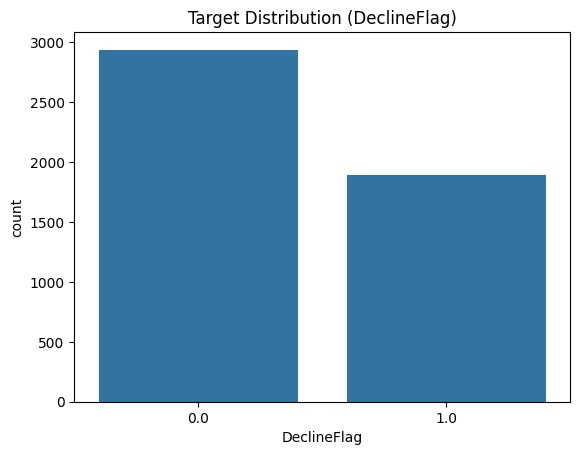

In [54]:
TARGET = "DeclineFlag"

print("Target distribution:")
print(df[TARGET].value_counts(dropna=False))
sns.countplot(x=TARGET, data=df)
plt.title("Target Distribution (DeclineFlag)")
plt.show()


## Run Preprocessing Pipeline

In [55]:
# Fit + transform preprocessing
X, y, pipeline = preprocess_fit_transform(df)

print("Processed feature matrix shape:", X.shape)
print("Target length:", len(y))

Processed feature matrix shape: (4829, 233)
Target length: 4829


## Inspect Transformed Features

In [56]:
from src.features.transformers import DomainFeatureEngineer

# Copy raw DataFrame and add engineered features
df_eng = DomainFeatureEngineer().fit_transform(df)

print("Shape with engineered features:", df_eng.shape)
print("New columns:", set(df_eng.columns) - set(df.columns))

# Now df_eng has age_at_transfer, contract_years_left, value_ratio, etc.
df_eng.head()

Shape with engineered features: (4829, 27)
New columns: {'market_premium', 'contract_years_left', 'value_ratio', 'from_league_strength', 'age_at_transfer', 'to_league_strength', 'league_strength_change'}


,from_league,to_league,Position,sub_position,position,foot,GA90_pre,GA_pre,PreMinutes,transfer_fee,market_value_in_eur,market_value_in_eur_player,highest_market_value_in_eur,country_of_birth,country_of_citizenship,height_in_cm,transfer_date,date_of_birth,contract_expiration_date,DeclineFlag,age_at_transfer,contract_years_left,value_ratio,market_premium,from_league_strength,to_league_strength,league_strength_change
0,GR1,TR1,Midfielder,Central Midfield,Midfield,left,0.091993,3.0,2935.0,0.0,2000000.0,1500000.0,14000000.0,Netherlands,Netherlands,175.0,2025-02-07,1995-01-03 00:00:00,2025-06-30 00:00:00,0.0,30.097194,0.391513,0.0,0.107143,1.0,3.0,2.0
1,GB1,NL1,FullBack,Left-Back,Defender,left,0.000000,0.0,1276.0,0.0,15000000.0,12000000.0,22000000.0,Netherlands,Netherlands,169.0,2025-02-04,1999-08-17 00:00:00,2025-06-30 00:00:00,1.0,25.470226,0.399726,0.0,0.545455,5.0,3.0,-2.0
2,IT1,IT1,FullBack,Left-Back,Defender,left,0.288462,15.0,4680.0,0.0,2000000.0,2000000.0,12000000.0,Italy,Italy,185.0,2025-02-03,1992-09-01 00:00:00,2025-06-30 00:00:00,1.0,32.424367,0.402464,0.0,0.166667,5.0,5.0,0.0
3,ES1,ES1,FullBack,Left-Back,Defender,left,0.275229,4.0,1308.0,0.0,2500000.0,2500000.0,20000000.0,Spain,Spain,170.0,2025-02-03,1993-03-01 00:00:00,2025-06-30 00:00:00,1.0,31.928816,0.402464,0.0,0.125000,5.0,5.0,0.0
4,GB1,SC1,Midfielder,Left Midfield,Midfield,left,0.284710,9.0,2845.0,0.0,6000000.0,5000000.0,12000000.0,Germany,Ghana,178.0,2025-02-03,1992-12-23 00:00:00,2025-05-31 00:00:00,1.0,32.114990,0.320329,0.0,0.416667,5.0,1.0,-4.0


## Sanity Plots for Engineered Features

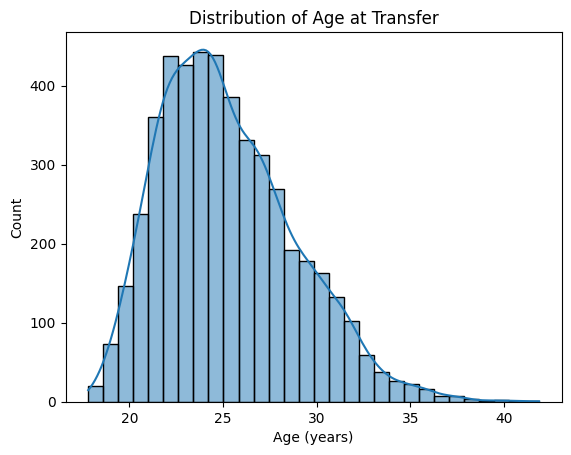

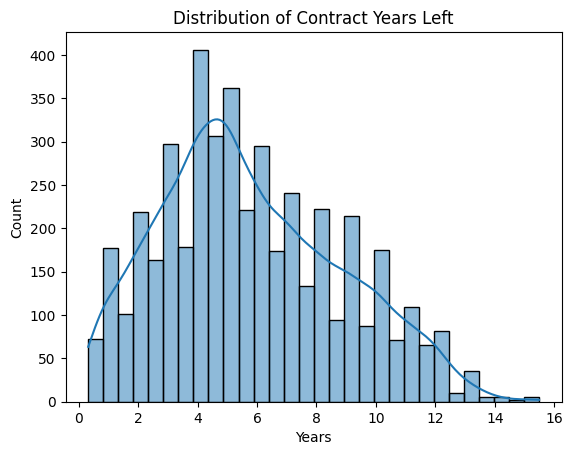

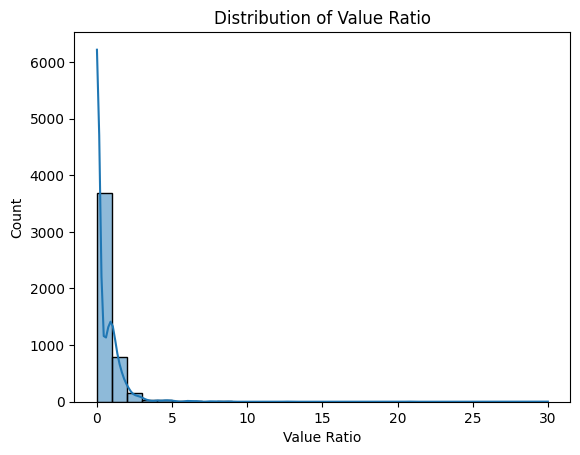

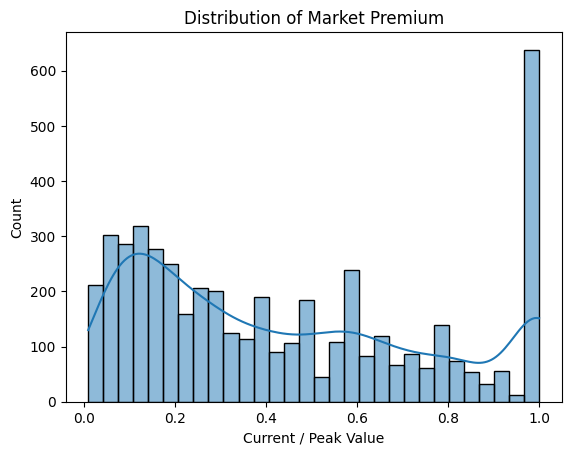

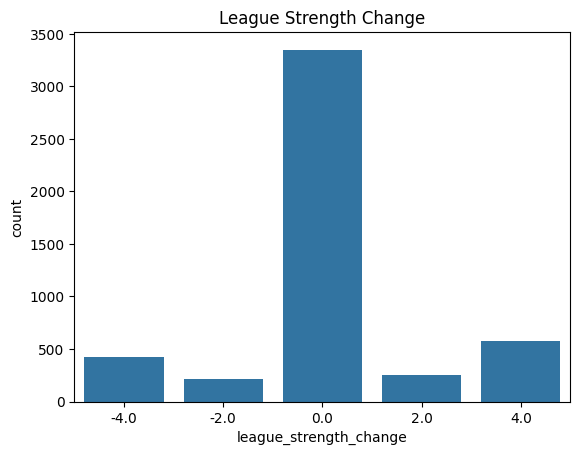

In [57]:
# Age at transfer
sns.histplot(df_eng["age_at_transfer"].dropna(), bins=30, kde=True)
plt.title("Distribution of Age at Transfer")
plt.xlabel("Age (years)")
plt.show()

# Contract years left
sns.histplot(df_eng["contract_years_left"].dropna(), bins=30, kde=True)
plt.title("Distribution of Contract Years Left")
plt.xlabel("Years")
plt.show()

# Value ratio
sns.histplot(df_eng["value_ratio"].dropna(), bins=30, kde=True)
plt.title("Distribution of Value Ratio")
plt.xlabel("Value Ratio")
plt.show()

# Market premium
sns.histplot(df_eng["market_premium"].dropna(), bins=30, kde=True)
plt.title("Distribution of Market Premium")
plt.xlabel("Current / Peak Value")
plt.show()

# League strength movement
sns.countplot(x="league_strength_change", data=df_eng)
plt.title("League Strength Change")
plt.show()

## Relationships & Correlations

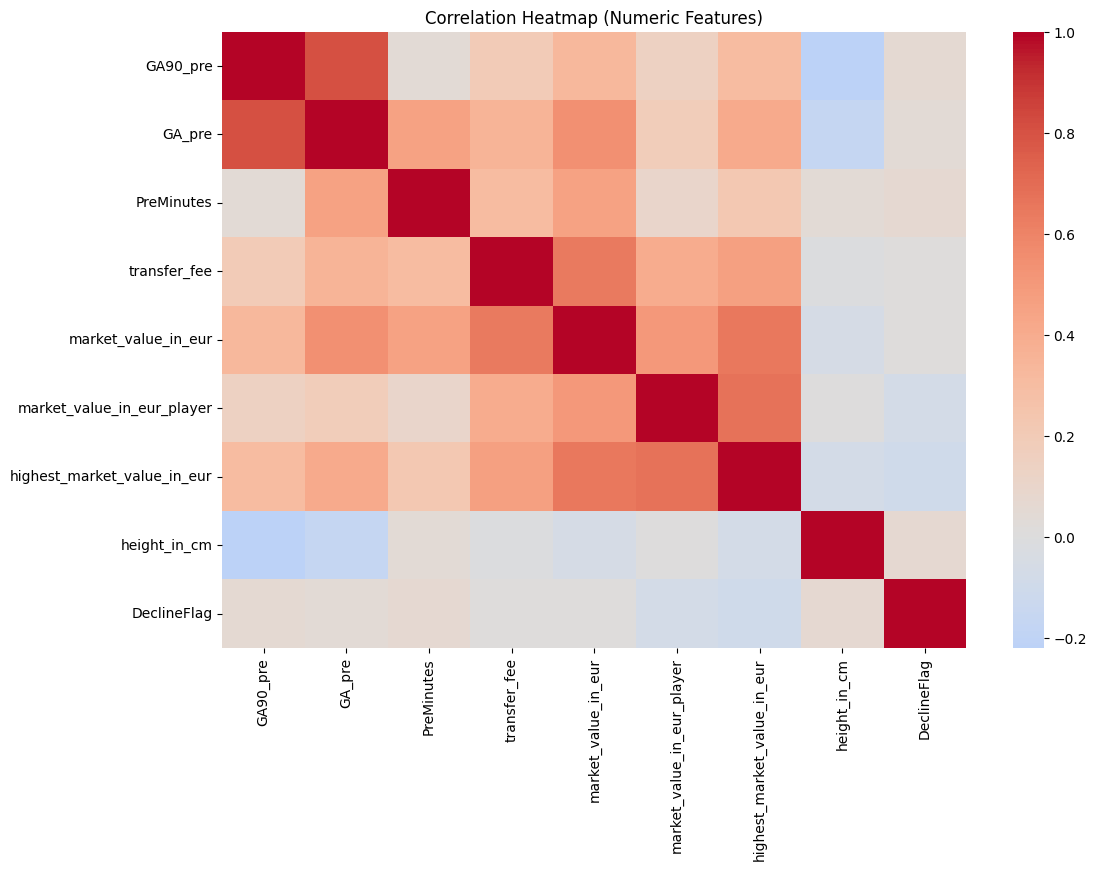

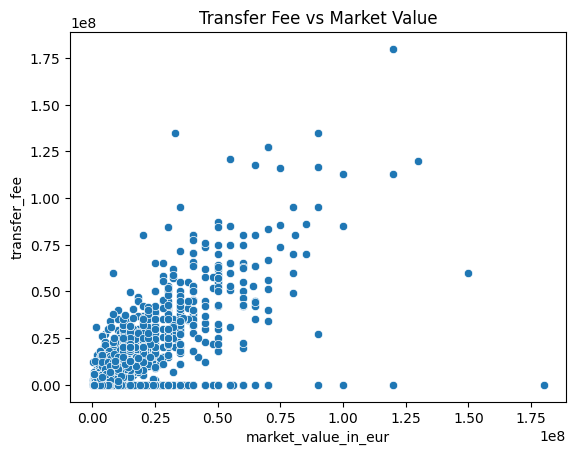

In [58]:
# Correlation heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

# Example scatter
sns.scatterplot(x="market_value_in_eur", y="transfer_fee", data=df)
plt.title("Transfer Fee vs Market Value")
plt.show()

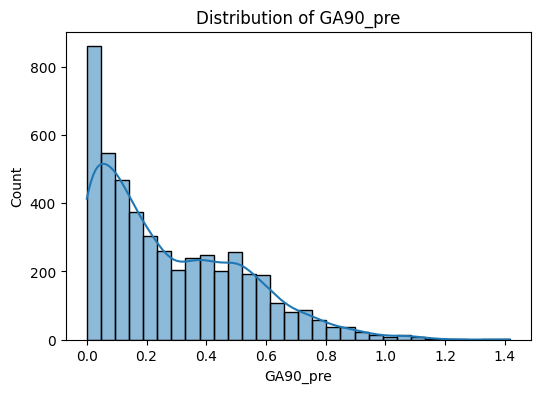

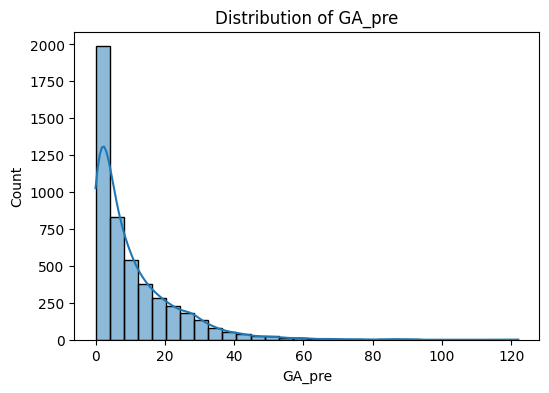

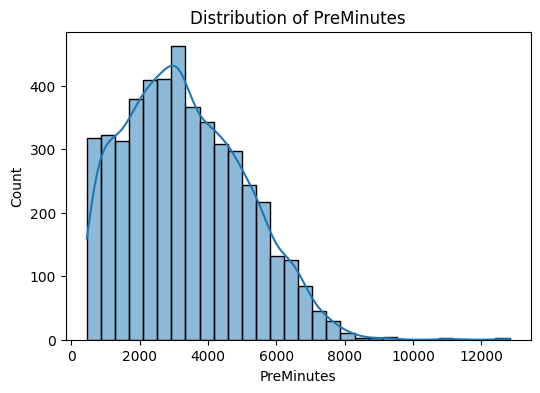

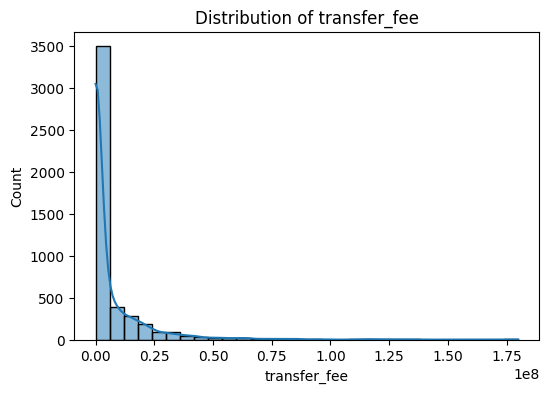

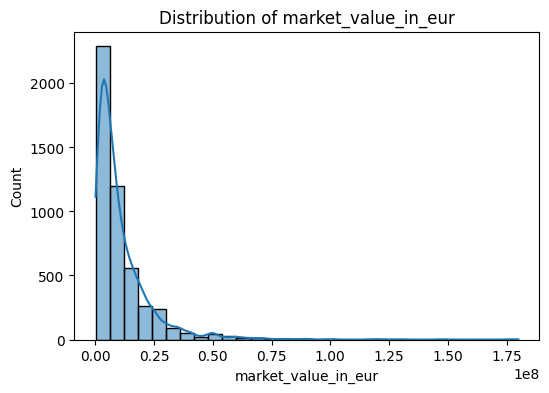

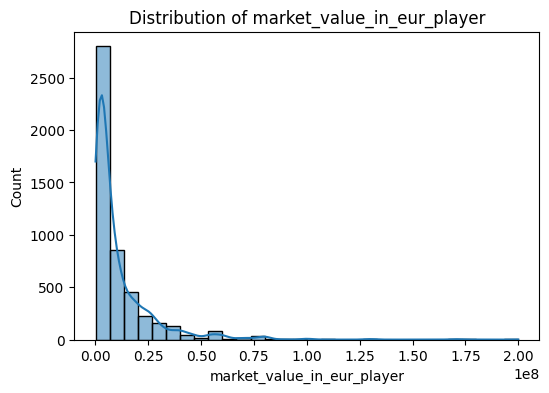

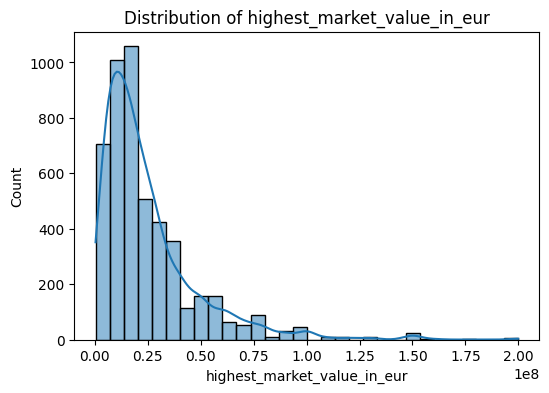

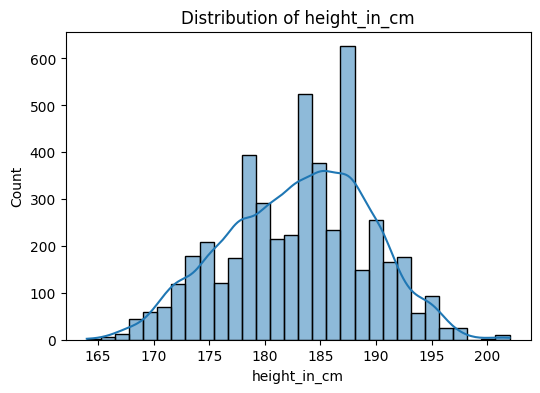

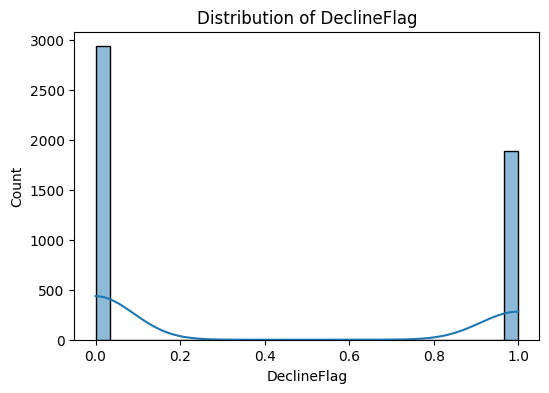

In [60]:
## Univariate Distribution Plots
# Numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

## Outlier Detection

Rows with >3 std outliers: 344


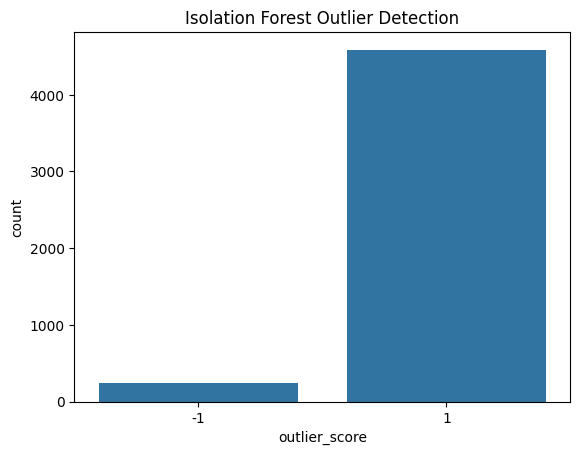

In [61]:
# Z-score method
z_scores = np.abs(stats.zscore(df[numeric_cols].dropna()))
outliers = (z_scores > 3).sum(axis=1)
print("Rows with >3 std outliers:", (outliers > 0).sum())

# Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
df["outlier_score"] = iso.fit_predict(df[numeric_cols].fillna(0))
sns.countplot(x="outlier_score", data=df)
plt.title("Isolation Forest Outlier Detection")
plt.show()

## Time-Series & Lag Inspection (Exploratory Only) 

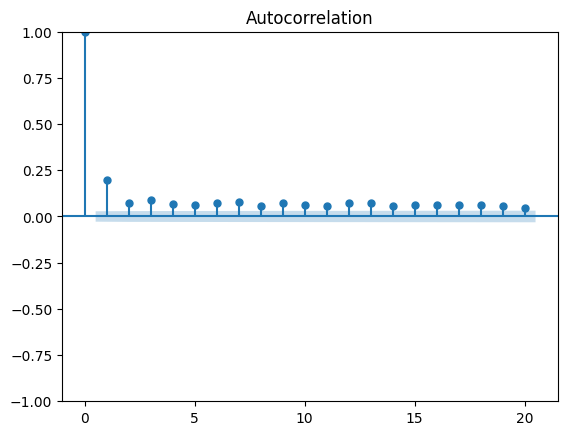

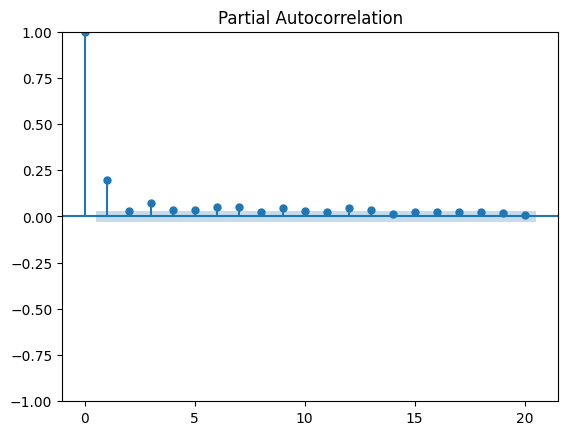

In [63]:
# Example lag on PreMinutes
df["PreMinutes_lag1"] = df["PreMinutes"].shift(1)

# ACF / PACF
plot_acf(df["PreMinutes"].dropna(), lags=20)
plt.show()

plot_pacf(df["PreMinutes"].dropna(), lags=20)
plt.show()

In [64]:
# Preprocessing pipeline
X, y, pipeline = preprocess_fit_transform(df)

print("Processed feature matrix shape:", X.shape)
print("Target length:", len(y))

Processed feature matrix shape: (4829, 233)
Target length: 4829


In [68]:
# Convert to dense if needed
if hasattr(X, "toarray"):
    X_dense = X.toarray()
else:
    X_dense = X

# Recover feature names from ColumnTransformer directly
num_cols = pipeline.named_steps["preprocessor"].transformers_[0][2]
cat_encoder = pipeline.named_steps["preprocessor"].transformers_[1][1].named_steps["encoder"]
cat_input_cols = pipeline.named_steps["preprocessor"].transformers_[1][2]
cat_cols = cat_encoder.get_feature_names_out(cat_input_cols)

# Only keep engineered features that survived pipeline
engineered = ["age_at_transfer", "contract_years_left", "value_ratio", "market_premium", "league_strength_change"]
other_cols = [f for f in engineered if f in df.columns]

# Final list
feature_names = list(num_cols) + list(cat_cols) + other_cols

# Build DataFrame
X_df = pd.DataFrame(X_dense, columns=feature_names, index=df.index)
print("Transformed DataFrame shape:", X_df.shape)
X_df.head()

Transformed DataFrame shape: (4829, 233)


,GA90_pre,GA_pre,PreMinutes,transfer_fee,market_value_in_eur,market_value_in_eur_player,highest_market_value_in_eur,height_in_cm,from_league_BE1,from_league_DK1,from_league_ES1,from_league_FR1,from_league_GB1,from_league_GR1,from_league_IT1,from_league_L1,from_league_NL1,from_league_PO1,from_league_RU1,from_league_SC1,from_league_TR1,from_league_UKR1,to_league_BE1,to_league_DK1,to_league_ES1,to_league_FR1,to_league_GB1,to_league_GR1,to_league_IT1,to_league_L1,to_league_NL1,to_league_PO1,to_league_RU1,to_league_SC1,to_league_TR1,to_league_UKR1,Position_AttMid_Winger,Position_CenterBack,Position_Forward,Position_FullBack,Position_GoalKeeper,Position_Midfielder,sub_position_Attacking Midfield,sub_position_Central Midfield,sub_position_Centre-Back,sub_position_Centre-Forward,sub_position_Defensive Midfield,sub_position_Goalkeeper,sub_position_Left Midfield,sub_position_Left Winger,sub_position_Left-Back,sub_position_Right Midfield,sub_position_Right Winger,sub_position_Right-Back,sub_position_Second Striker,position_Attack,position_Defender,position_Goalkeeper,position_Midfield,foot_both,...,country_of_citizenship_Ecuador,country_of_citizenship_Egypt,country_of_citizenship_England,country_of_citizenship_Equatorial Guinea,country_of_citizenship_Finland,country_of_citizenship_France,country_of_citizenship_French Guiana,country_of_citizenship_Gabon,country_of_citizenship_Georgia,country_of_citizenship_Germany,country_of_citizenship_Ghana,country_of_citizenship_Greece,country_of_citizenship_Guadeloupe,country_of_citizenship_Guinea,country_of_citizenship_Guinea-Bissau,country_of_citizenship_Hungary,country_of_citizenship_Iran,country_of_citizenship_Ireland,country_of_citizenship_Israel,country_of_citizenship_Italy,country_of_citizenship_Jamaica,country_of_citizenship_Japan,country_of_citizenship_Kosovo,country_of_citizenship_Mali,country_of_citizenship_Mexico,country_of_citizenship_Morocco,country_of_citizenship_Mozambique,country_of_citizenship_Netherlands,country_of_citizenship_New Zealand,country_of_citizenship_Nigeria,country_of_citizenship_North Macedonia,country_of_citizenship_Northern Ireland,country_of_citizenship_Norway,country_of_citizenship_Paraguay,country_of_citizenship_Peru,country_of_citizenship_Poland,country_of_citizenship_Portugal,country_of_citizenship_Romania,country_of_citizenship_Russia,country_of_citizenship_Scotland,country_of_citizenship_Senegal,country_of_citizenship_Serbia,country_of_citizenship_Sierra Leone,country_of_citizenship_Slovakia,country_of_citizenship_Slovenia,country_of_citizenship_Spain,country_of_citizenship_Suriname,country_of_citizenship_Sweden,country_of_citizenship_Switzerland,country_of_citizenship_The Gambia,country_of_citizenship_Togo,country_of_citizenship_Tunisia,country_of_citizenship_Türkiye,country_of_citizenship_Ukraine,country_of_citizenship_United States,country_of_citizenship_Uruguay,country_of_citizenship_Uzbekistan,country_of_citizenship_Venezuela,country_of_citizenship_Wales,country_of_citizenship_Zimbabwe
0,-0.769474,-0.632345,-0.227360,-0.440147,-0.701237,-0.593453,-0.476844,-1.260203,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.147755,-0.883428,-1.177336,-0.440147,0.326208,0.068976,-0.138966,-2.198240,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

## Model-Based Feature Selection Diagnostics

In [74]:
from sklearn.ensemble import RandomForestClassifier

X, y, pipeline = preprocess_fit_transform(df)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1][:20]

# plt.figure(figsize=(10,6))
# plt.bar(range(len(indices)), importances[indices], align="center")
# plt.xticks(range(len(indices)), [indices[i] for i in range(len(indices))], rotation=90)
# plt.title("Top 20 Feature Importances (RandomForest)")
# plt.show()


In [75]:
# Extract numeric feature names
num_cols = pipeline.named_steps["preprocessor"].transformers_[0][2]

# Extract categorical feature names from OneHotEncoder
cat_encoder = pipeline.named_steps["preprocessor"].transformers_[1][1].named_steps["encoder"]
cat_cols = cat_encoder.get_feature_names_out(
    pipeline.named_steps["preprocessor"].transformers_[1][2]
)

# Engineered domain features (added before ColumnTransformer)
domain_features = ["age_at_transfer", "contract_years_left", 
                   "value_ratio", "market_premium", "league_strength_change"]

# Combine all
feature_names = list(num_cols) + list(cat_cols) + domain_features
print("Total features recovered:", len(feature_names))

Total features recovered: 238


In [76]:
# Top 20 features with names
top_indices = np.argsort(importances)[::-1][:20]
top_features = [(feature_names[i], importances[i]) for i in top_indices]

# Display nicely
for f, imp in top_features:
    print(f"{f:30s} {imp:.4f}")


GA90_pre                       0.1272
PreMinutes                     0.0872
GA_pre                         0.0796
market_value_in_eur            0.0716
highest_market_value_in_eur    0.0582
market_value_in_eur_player     0.0513
height_in_cm                   0.0478
transfer_fee                   0.0396
position_Goalkeeper            0.0180
Position_GoalKeeper            0.0160
sub_position_Goalkeeper        0.0149
to_league_IT1                  0.0104
foot_right                     0.0101
foot_left                      0.0098
from_league_IT1                0.0096
to_league_GB1                  0.0095
from_league_GB1                0.0085
from_league_FR1                0.0084
to_league_ES1                  0.0083
from_league_ES1                0.0077


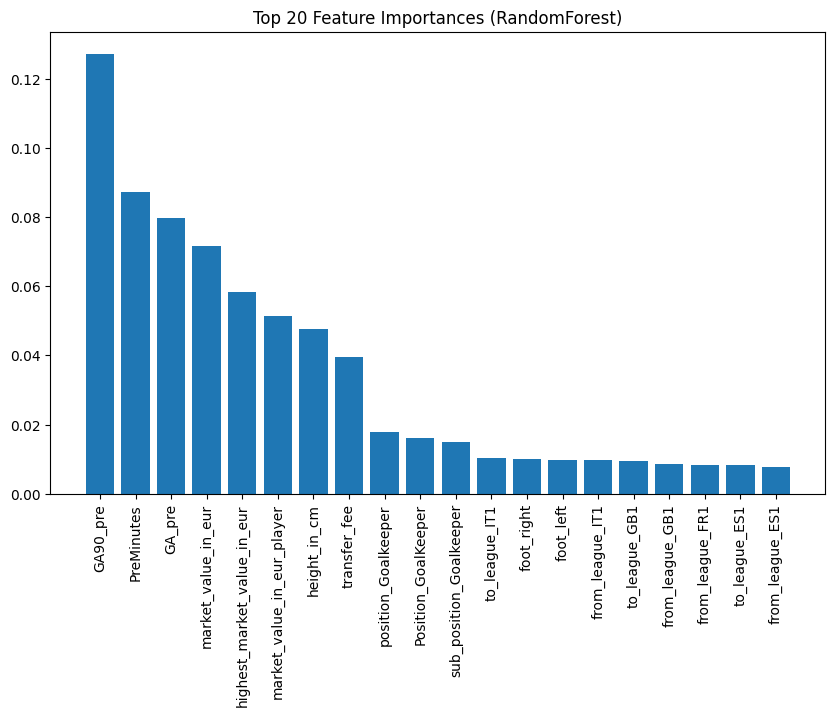

In [77]:
plt.figure(figsize=(10,6))
plt.bar(range(len(top_indices)), importances[top_indices], align="center")
plt.xticks(range(len(top_indices)), [feature_names[i] for i in top_indices], rotation=90)
plt.title("Top 20 Feature Importances (RandomForest)")
plt.show()